# GAN for celebrity face generation

This is my implementation of [PyTorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) on celebrity face generation using GANS

## Dataset

For training the model the we will use the same dataset used in the original tutorial. It can be downloaded from this [link](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). If the previous link does not work, you can download the data from [archive.org](https://archive.org/details/celeba)

## Loading the Data

In [19]:
import torch
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils 
import matplotlib.pyplot as plt
import numpy as np

In [12]:
fileroot = '../data'
device = "cuda"
image_size = 64
batch_size = 128

In [14]:
transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = dset.ImageFolder(fileroot, transform=transforms)

In [15]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

we can now visualize some training examples

NameError: name 'vutils' is not defined

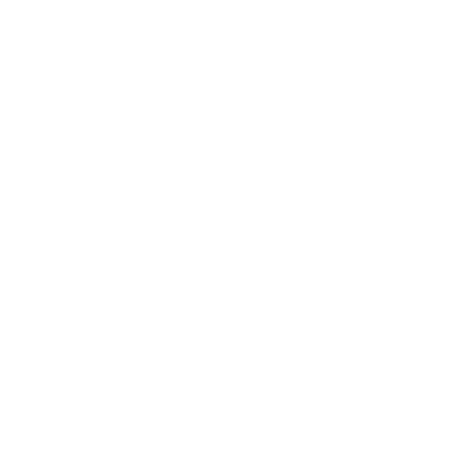

In [18]:
sample_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0].to(device), padding=2, normalize=True).cpu(),
    (1,2,0)))